In [884]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [885]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [886]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


Load and prepare data


In [887]:
data = pd.read_csv("./data/rnn_full_data.csv")
data

,Year,Month,District,Location Group,holiday_count,sin_month,cos_month,crime_count
0,2018,1,1.0,EDUCATIONAL,2.0,0.0,1.000000,28.0
1,2018,1,1.0,FINANCIAL,2.0,0.0,1.000000,23.0
2,2018,1,1.0,FOOD_ENTERTAINMENT,2.0,0.0,1.000000,189.0
3,2018,1,1.0,GOVERNMENT,2.0,0.0,1.000000,16.0
4,2018,1,1.0,OFFICE_BUSINESS,2.0,0.0,1.000000,28.0
...,...,...,...,...,...,...,...,...
20220,2024,12,25.0,STREET_OUTDOOR,1.0,-0.5,0.866025,311.0
20221,2024,12,25.0,TRANSPORTATION,1.0,-0.5,0.866025,26.0
20222,2024,12,31.0,OTHER,1.0,-0.5,0.866025,1.0
20223,2024,12,31.0,RETAIL,1.0,-0.5,0.866025,1.0


Create a unique location identifier and time key


In [888]:
data["District"].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14.,
       15., 16., 17., 18., 19., 20., 22., 24., 25., 31.])

In [889]:
data["time_key"] = data["Year"] * 12 + data["Month"]
data["location_key"] = data["Location Group"] + "_" + data["District"].astype(str)
data

,Year,Month,District,Location Group,holiday_count,sin_month,cos_month,crime_count,time_key,location_key
0,2018,1,1.0,EDUCATIONAL,2.0,0.0,1.000000,28.0,24217,EDUCATIONAL_1.0
1,2018,1,1.0,FINANCIAL,2.0,0.0,1.000000,23.0,24217,FINANCIAL_1.0
2,2018,1,1.0,FOOD_ENTERTAINMENT,2.0,0.0,1.000000,189.0,24217,FOOD_ENTERTAINMENT_1.0
3,2018,1,1.0,GOVERNMENT,2.0,0.0,1.000000,16.0,24217,GOVERNMENT_1.0
4,2018,1,1.0,OFFICE_BUSINESS,2.0,0.0,1.000000,28.0,24217,OFFICE_BUSINESS_1.0
...,...,...,...,...,...,...,...,...,...,...
20220,2024,12,25.0,STREET_OUTDOOR,1.0,-0.5,0.866025,311.0,24300,STREET_OUTDOOR_25.0
20221,2024,12,25.0,TRANSPORTATION,1.0,-0.5,0.866025,26.0,24300,TRANSPORTATION_25.0
20222,2024,12,31.0,OTHER,1.0,-0.5,0.866025,1.0,24300,OTHER_31.0
20223,2024,12,31.0,RETAIL,1.0,-0.5,0.866025,1.0,24300,RETAIL_31.0


Get unique locations and time points


In [890]:
locations = data["location_key"].unique()
locations.sort()
n_location = len(locations)
time_points = sorted(data["time_key"].unique())
n_time = len(time_points)
location_map = {location: i for i, location in enumerate(locations)}
time_map = {time_point: i for i, time_point in enumerate(time_points)}
data["location_id"] = data["location_key"].map(location_map)
data["time_id"] = data["time_key"].map(time_map)
print(location_map)
print(time_map)

{'EDUCATIONAL_1.0': 0, 'EDUCATIONAL_10.0': 1, 'EDUCATIONAL_11.0': 2, 'EDUCATIONAL_12.0': 3, 'EDUCATIONAL_14.0': 4, 'EDUCATIONAL_15.0': 5, 'EDUCATIONAL_16.0': 6, 'EDUCATIONAL_17.0': 7, 'EDUCATIONAL_18.0': 8, 'EDUCATIONAL_19.0': 9, 'EDUCATIONAL_2.0': 10, 'EDUCATIONAL_20.0': 11, 'EDUCATIONAL_22.0': 12, 'EDUCATIONAL_24.0': 13, 'EDUCATIONAL_25.0': 14, 'EDUCATIONAL_3.0': 15, 'EDUCATIONAL_4.0': 16, 'EDUCATIONAL_5.0': 17, 'EDUCATIONAL_6.0': 18, 'EDUCATIONAL_7.0': 19, 'EDUCATIONAL_8.0': 20, 'EDUCATIONAL_9.0': 21, 'FINANCIAL_1.0': 22, 'FINANCIAL_10.0': 23, 'FINANCIAL_11.0': 24, 'FINANCIAL_12.0': 25, 'FINANCIAL_14.0': 26, 'FINANCIAL_15.0': 27, 'FINANCIAL_16.0': 28, 'FINANCIAL_17.0': 29, 'FINANCIAL_18.0': 30, 'FINANCIAL_19.0': 31, 'FINANCIAL_2.0': 32, 'FINANCIAL_20.0': 33, 'FINANCIAL_22.0': 34, 'FINANCIAL_24.0': 35, 'FINANCIAL_25.0': 36, 'FINANCIAL_3.0': 37, 'FINANCIAL_31.0': 38, 'FINANCIAL_4.0': 39, 'FINANCIAL_5.0': 40, 'FINANCIAL_6.0': 41, 'FINANCIAL_7.0': 42, 'FINANCIAL_8.0': 43, 'FINANCIAL_9.0

In [891]:
print(f"Number of unique locations: {len(locations)}")
print(f"Number of time points: {len(time_points)}")
data.describe()

Number of unique locations: 251
Number of time points: 84


,Year,Month,District,holiday_count,sin_month,cos_month,crime_count,time_key,location_id,time_id
count,20225.000000,20225.000000,20225.000000,20225.000000,20225.000000,2.022500e+04,20225.000000,20225.000000,20225.000000,20225.000000
mean,2021.000692,6.500025,12.239802,0.881088,-0.000303,3.805267e-04,83.412410,24258.508331,124.929197,41.508331
std,2.002767,3.453095,7.219549,0.661999,0.707080,7.071679e-01,131.593961,24.279982,72.342657,24.279982
min,2018.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000e+00,1.000000,24217.000000,0.000000,0.000000
25%,2019.000000,3.000000,6.000000,0.000000,-0.866025,-5.000000e-01,11.000000,24237.000000,62.000000,20.000000
50%,2021.000000,7.000000,12.000000,1.000000,0.000000,6.123234e-17,25.000000,24259.000000,125.000000,42.000000
75%,2023.000000,10.000000,18.000000,1.000000,0.500000,8.660254e-01,69.000000,24280.000000,187.000000,63.000000
max,2024.000000,12.000000,31.000000,2.000000,1.000000,1.000000e+00,989.000000,24300.000000,250.000000,83.000000


In [917]:
cat_features = ["location_id"]
num_features = ["crime_count", "holiday_count", "Year", "sin_month", "cos_month"]

In [918]:
cat_matrix = np.zeros((len(time_points), len(locations), len(cat_features)))
num_matrix = np.zeros((len(time_points), len(locations), len(num_features)))

In [919]:
for _, row in data.iterrows():
    location_id = round(row["location_id"])
    time_id = round(row["time_id"])
    cat_matrix[time_id, location_id] = row[cat_features]
    num_matrix[time_id, location_id] = row[num_features]
cat_matrix.shape, num_matrix.shape

((84, 251, 1), (84, 251, 5))

In [920]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
matrix_scaled = num_matrix.copy()
matrix_scaled = scaler.fit_transform(num_matrix.reshape(-1, 1)).reshape(
    num_matrix.shape
)

In [921]:
seq_length = 12

In [922]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        target = data[i + seq_length, :, 0]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

Create sequences


In [923]:
X_cat, _ = create_sequences(cat_matrix, seq_length)
X_num, y = create_sequences(num_matrix, seq_length)
print(X_cat.shape)
print(X_num.shape)
print(y.shape)

(72, 12, 251, 1)
(72, 12, 251, 5)
(72, 251)


In [925]:
print(f"Number of sequences: {len(X_cat)}")
print(
    f"Categorical Input shape: {X_cat.shape}"
)  # [n_sequences, seq_length, n_locations, n_features]
print(
    f"Numerical Input shape: {X_num.shape}"
)  # [n_sequences, seq_length, n_locations, n_features]
print(f"Target shape: {y.shape}")  # [n_sequences, n_locations]

Number of sequences: 72
Categorical Input shape: (72, 12, 251, 1)
Numerical Input shape: (72, 12, 251, 5)
Target shape: (72, 251)


In [ ]:
train_size = int(0.75 * len(X_cat))
X_train, X_val = (X_cat[:train_size], X_num[:train_size]), (
    X_cat[train_size:],
    X_num[train_size:],
)
y_train, y_val = y[:train_size], y[train_size:]

2 2


In [930]:
print(f"Training sequences: {len(X_train[0])}")
print(f"Validation sequences: {len(X_val[0])}")

Training sequences: 54
Validation sequences: 18


Convert to PyTorch tensors


In [ ]:
X_train = (
    torch.tensor(X_train[0], dtype=torch.float32).to(device),
    torch.tensor(X_train[1], dtype=torch.float32).to(device),
)
X_val = (
    torch.tensor(X_val[0], dtype=torch.float32).to(device),
    torch.tensor(X_val[1], dtype=torch.float32).to(device),
)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

/var/folders/sx/pmvfmfnd1yb2twxrjn65_p0m0000gn/T/ipykernel_30112/4090087561.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X_train_tensor = torch.FloatTensor(X_train).to(device)


ValueError: expected sequence of length 1 at dim 4 (got 5)

Define the RNN model


In [903]:
input_size = len(features) - 1
hidden_size = 32
batch_size = 16
num_layers = 3
embed_dim = 8
output_size = 1
num_epochs = 50

In [904]:
class CrimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embed_dim, num_layers, output_size):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.location_embedding = nn.Embedding(len(locations), embed_dim)
        self.lstm = nn.LSTM(
            input_size=input_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, h_0, c_0):
        # x: [seq_length, batch_size, n_features (crime_count, location_id)]

        # location_embed: [seq_length, batch_size, embed_dim]
        location_embed = self.location_embedding(x[:, :, 1].long())
        # crime: [seq_length, batch_size, 1]
        crime = x[:, :, 0].unsqueeze(-1)
        num = x[:, :, 2:]
        # Combine crime and location embeddings
        x = torch.cat((crime, location_embed, num), dim=-1)
        # x: [seq_length, batch_size, embed_dim + 1]
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        output = self.fc1(output[-1])
        output = self.relu(output)
        output = self.fc2(output)

        return output, (h_n, c_n)

In [905]:
print(X_train.shape)
model = CrimeLSTM(input_size, hidden_size, embed_dim, num_layers, output_size).to(
    device
)
print(model)

(54, 12, 251, 5)
CrimeLSTM(
  (location_embedding): Embedding(251, 8)
  (lstm): LSTM(12, 32, num_layers=3)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


Define loss function and optimizer


In [906]:
criterion = nn.MSELoss()

Training function


In [907]:
# Validation
def evaluate_model(model, X, y):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in range(0, n_location, batch_size):
            actual_batch_size = min(n_location - batch, batch_size)
            h = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
            for i in range(len(X_val)):
                sequence = X[i, :, batch : batch + batch_size]
                target = y[i, batch : batch + batch_size]
                h, c = h.detach(), c.detach()
                score, (h, c) = model(sequence, h, c)
                loss = criterion(score, target.unsqueeze(1))
                val_loss += loss.item()
                num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [908]:
start_time = time.time()
n_location = len(locations)
train_losses = []
val_losses = []
my_lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=my_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
n_seq = len(X_train)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for batch in range(0, n_location, batch_size):
        actual_batch_size = min(n_location - batch, batch_size)
        h = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
        c = torch.zeros(num_layers, actual_batch_size, hidden_size).to(device)
        for i in range(n_seq):
            optimizer.zero_grad()
            sequence = X_train_tensor[i, :, batch : batch + actual_batch_size]
            target = y_train_tensor[i, batch : batch + actual_batch_size]
            h, c = h.detach(), c.detach()
            score, (h, c) = model(sequence, h, c)
            loss = criterion(score, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
    scheduler.step()
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, X_val_tensor, y_val_tensor)
    val_losses.append(val_loss)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, learning rate: {scheduler.get_last_lr()[0]:.12f}, time: {time.time() - start_time:.2f} seconds"
    )

KeyboardInterrupt: 

Train the model


Plot training and validation loss


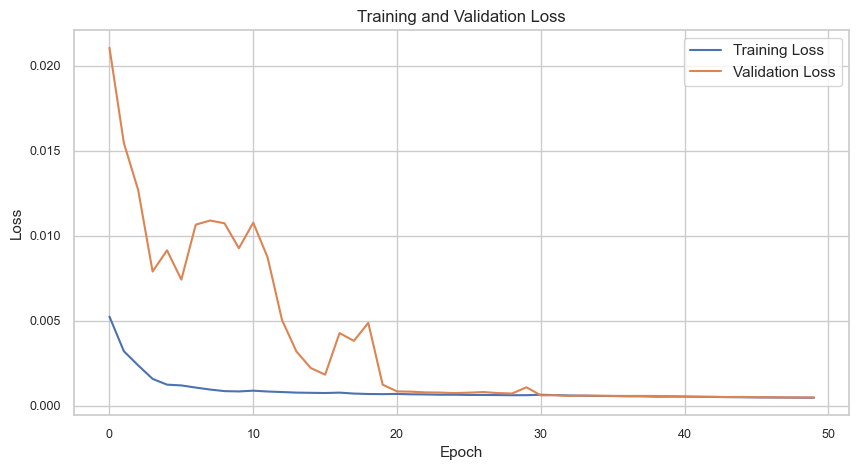

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss.pdf")
plt.show()

In [ ]:
def predictions(model, X, y):
    num_seq, _, n_location, n_features = X.shape
    result = np.zeros((num_seq, n_location, 2))
    with torch.no_grad():
        for i in range(len(X)):
            for batch in range(0, n_location, batch_size):
                batch_increment = min(batch_size, n_location - batch)
                sequence = X[i, :, batch : batch + batch_increment]
                target = y[i, batch : batch + batch_increment]
                score = model(sequence)
                result[i, batch : batch + batch_increment, 0] = (
                    score.cpu().numpy().flatten()
                )
                result[i, batch : batch + batch_increment, 1] = (
                    target.cpu().numpy().flatten()
                )
    return result

In [ ]:
prediction_model = model.to("mps")
result = predictions(model, X_val_tensor.to("mps"), y_val_tensor.to("mps"))
unscaled_result = scaler.inverse_transform(result.reshape(-1, 2)).reshape(result.shape)

TypeError: CrimeLSTM.forward() missing 2 required positional arguments: 'h_0' and 'c_0'

In [ ]:
unscaled_result

array([[[1095.24708128, 1075.0000124 ],
        [1090.34323502,  988.00001812],
        [1140.89343357, 1039.99998283],
        [1248.76508665, 1065.99996519],
        [ 876.17412376,  811.99999642],
        [1307.7861433 , 1138.00001669],
        [ 926.33065128,  789.99999881],
        [1354.99666119, 1246.0000124 ],
        [ 948.94056177,  852.00000691],
        [ 892.00919056,  841.00000811],
        [1214.67544174, 1074.00001621],
        [1258.78535175, 1137.0000205 ],
        [ 728.03382945,  736.99999714],
        [ 745.89273882,  620.99999118],
        [ 843.08374119,  714.00000334],
        [ 660.60726833,  568.00000989],
        [1160.65950298, 1043.99996758],
        [1117.90673065,  918.99999595],
        [ 458.65885818,  448.99999499],
        [ 690.69521618,  570.99999845],
        [ 758.10775256,  806.00001931],
        [1102.60183144, 1030.00002098]],

       [[1083.28748894, 1094.00002146],
        [1081.00969267,  987.00002193],
        [1128.73985958, 1037.99999046]

Overall Metrics Summary:
                    MAE    MAPE(%)        RMSE         R²
District_1    81.394008   6.527002   98.229362   0.414851
District_2   108.361065  10.356288  122.079496  -0.351418
District_3   179.622844  17.032187  204.945757  -5.036493
District_4   204.166336  18.160922  209.962922  -9.281283
District_5    98.284578  12.343831  117.352375  -1.084946
District_6   157.562381  13.547931  184.598388  -1.861974
District_7   112.013258  13.158679  123.948415  -1.176812
District_8    89.330431   6.351912  106.322439   0.271024
District_9   124.894623  13.557598  136.922341  -2.038355
District_10  108.151974  12.669510  122.161533  -3.210813
District_11  174.831844  15.961686  191.054536  -3.203010
District_12   80.839344   6.164379   90.677296   0.491163
District_13   67.595340   7.907940   80.458444   0.254434
District_14   88.862406  12.633516  100.969765  -1.824271
District_15  220.910602  30.053478  235.802751 -16.761360
District_16   93.017254  14.368599  108.978348 

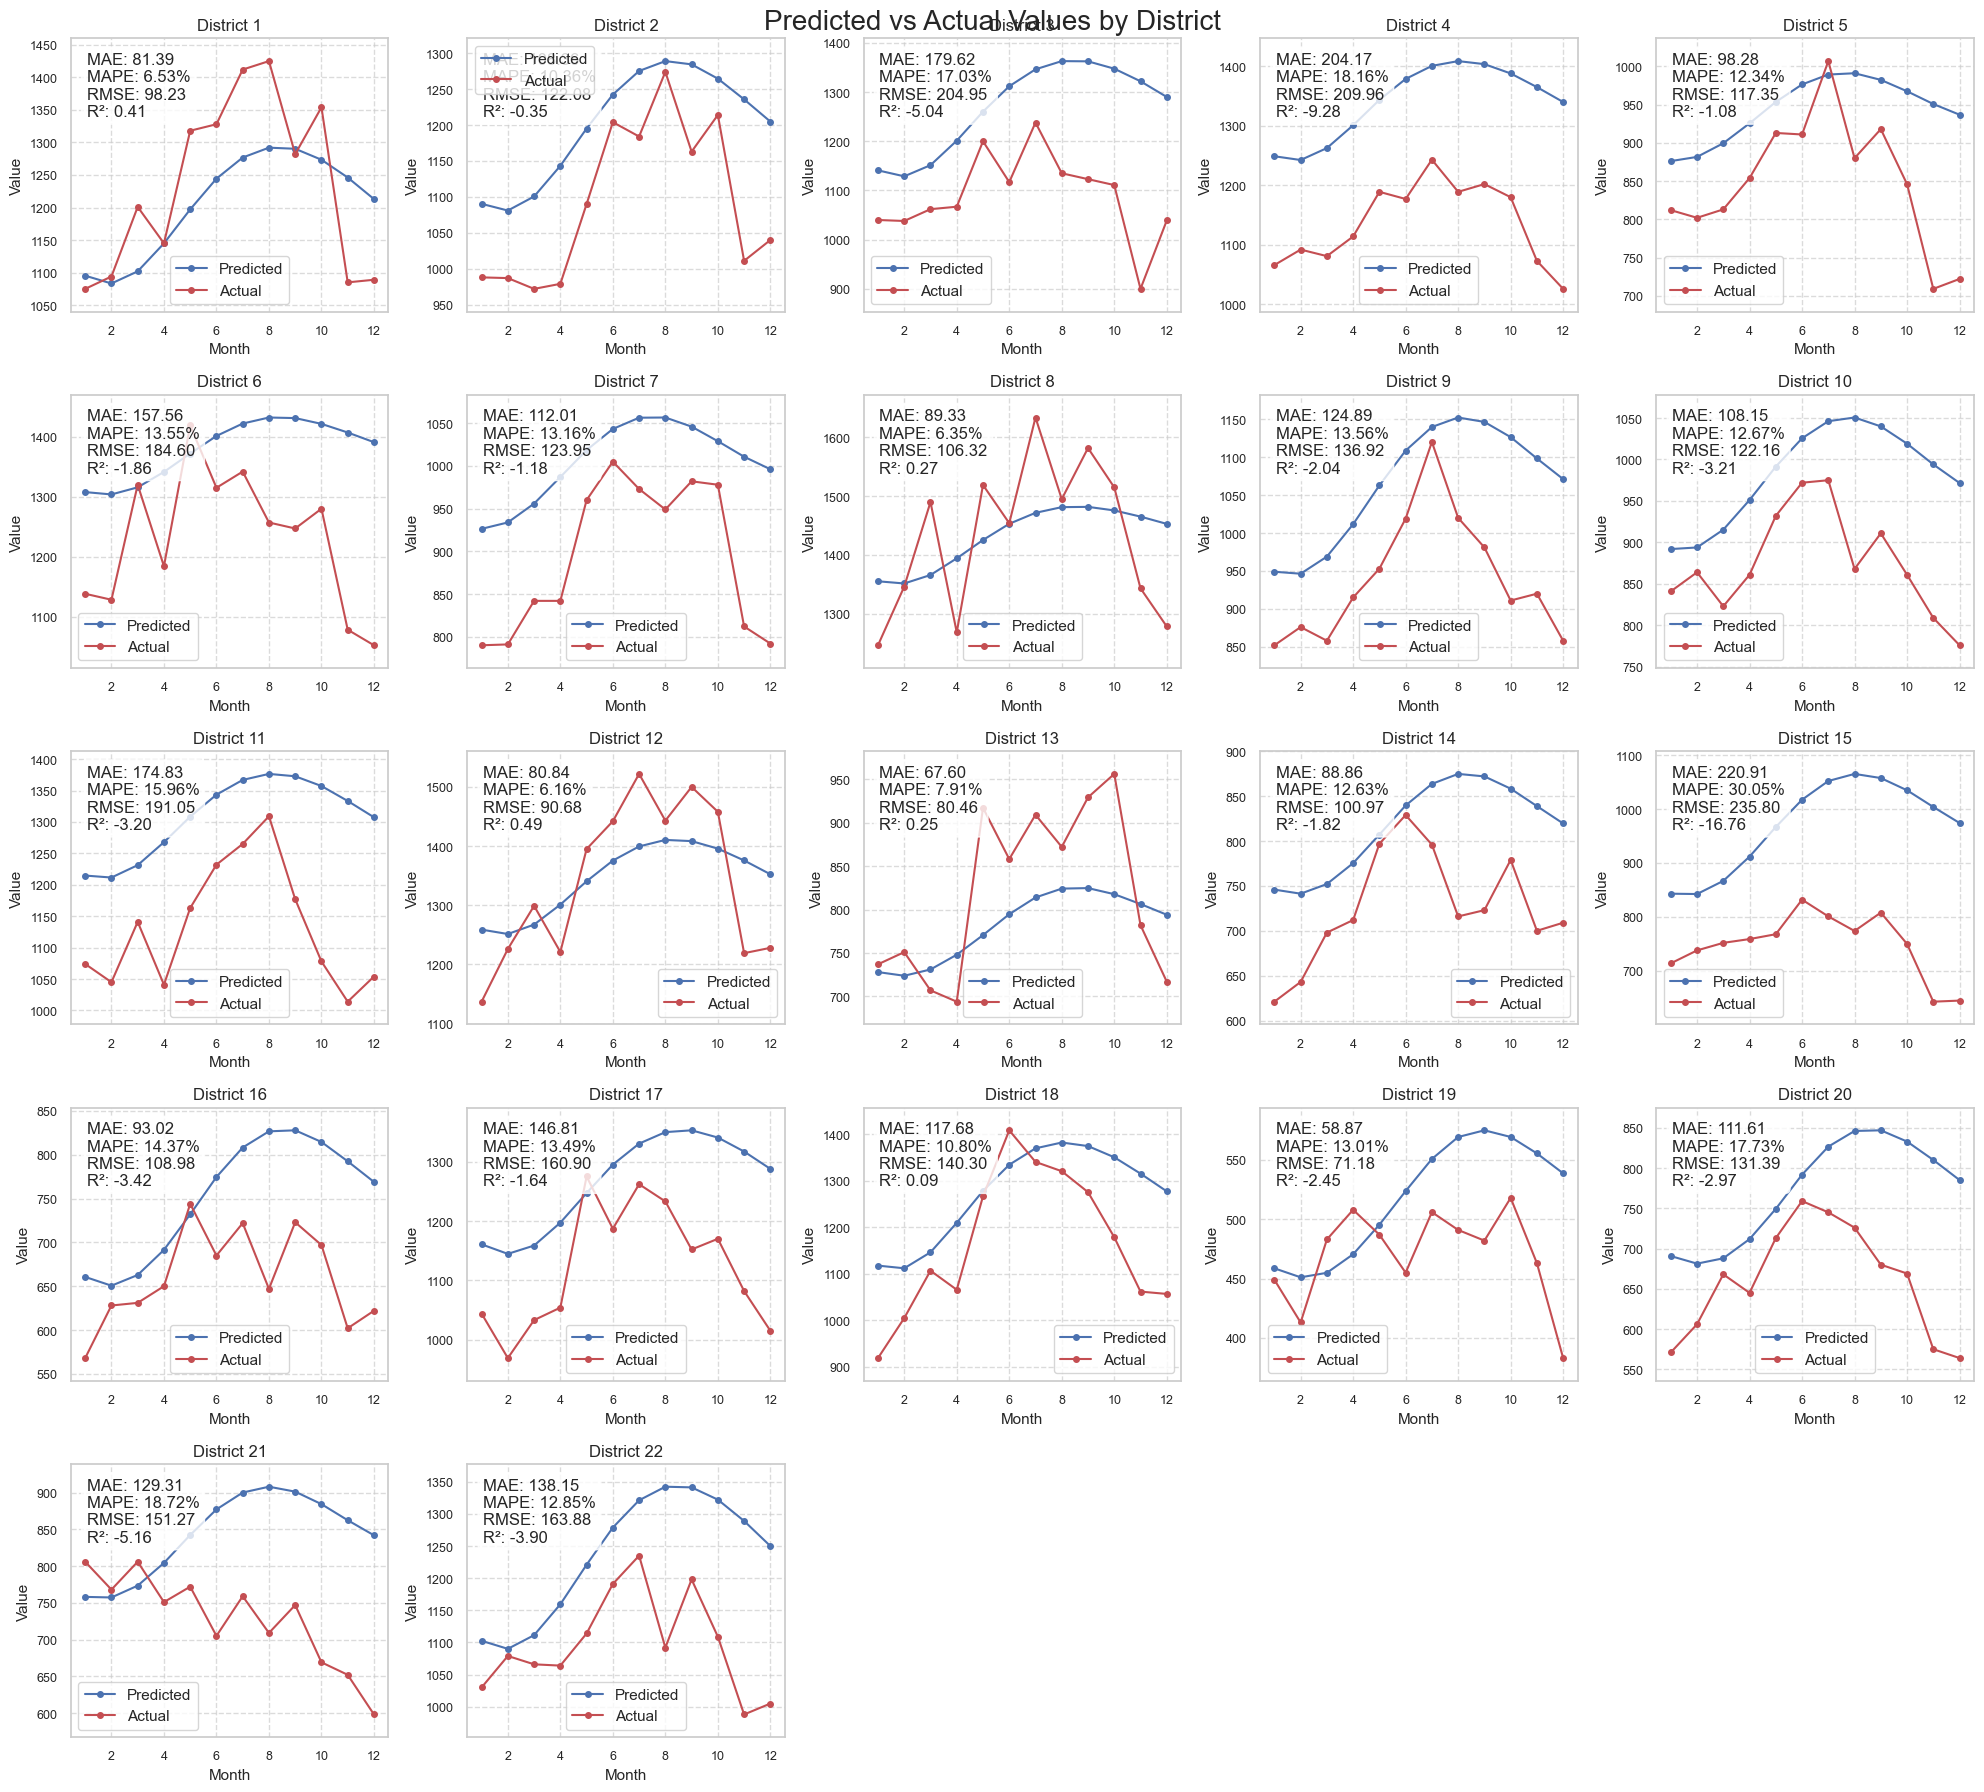

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def plot_district_predictions(data, save_path=None):
    """
    Plot predicted vs actual values for each district over time and calculate error metrics.

    Parameters:
    -----------
    data : numpy.ndarray
        3D array of shape (months, districts, 2) where the last dimension
        contains [predicted, actual] values.
    save_path : str, optional
        If provided, the figure will be saved to this path.

    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plots.
    dict
        Dictionary containing error metrics for each district.
    """
    num_months, num_districts, _ = data.shape

    # Determine grid size for subplots (5x5 grid to fit 23 districts)
    cols = 5
    rows = 5

    # Create figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 18))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Create x-axis data (months)
    months = np.arange(1, num_months + 1)

    # Dictionary to store metrics for each district
    metrics = {}

    # Plot each district
    for i in range(num_districts):
        ax = axes[i]

        # Extract predicted and actual values for this district
        predicted = data[:, i, 0]
        actual = data[:, i, 1]

        # Calculate metrics for non-NaN values
        valid_indices = ~np.isnan(predicted) & ~np.isnan(actual)
        valid_predicted = predicted[valid_indices]
        valid_actual = actual[valid_indices]

        if len(valid_actual) > 0:
            # Calculate Mean Absolute Error
            mae = mean_absolute_error(valid_actual, valid_predicted)

            # Calculate MAE percentage (MAPE)
            # Avoid division by zero by adding a small epsilon
            epsilon = 1e-10
            mape = (
                np.mean(
                    np.abs((valid_actual - valid_predicted) / (valid_actual + epsilon))
                )
                * 100
            )

            # Calculate Root Mean Squared Error
            rmse = np.sqrt(mean_squared_error(valid_actual, valid_predicted))

            # Calculate R-squared (coefficient of determination)
            r2 = r2_score(valid_actual, valid_predicted)

            # Store metrics
            metrics[f"District_{i+1}"] = {
                "MAE": mae,
                "MAPE(%)": mape,
                "RMSE": rmse,
                "R²": r2,
            }

            # Add metrics to the plot
            metrics_text = (
                f"MAE: {mae:.2f}\nMAPE: {mape:.2f}%\nRMSE: {rmse:.2f}\nR²: {r2:.2f}"
            )
            ax.text(
                0.05,
                0.95,
                metrics_text,
                transform=ax.transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
            )

        # Plot the data
        ax.plot(months, predicted, "b-o", label="Predicted", markersize=4)
        ax.plot(months, actual, "r-o", label="Actual", markersize=4)

        # Add title and labels
        ax.set_title(f"District {i+1}")
        ax.set_xlabel("Month")
        ax.set_ylabel("Value")

        # Add grid
        ax.grid(True, linestyle="--", alpha=0.7)

        # Add legend to each subplot
        ax.legend(loc="best")

        # Set y limits with a bit of padding
        all_values = np.concatenate([predicted, actual])

        # Filter out NaN values for computing limits
        valid_values = all_values[~np.isnan(all_values)]
        if len(valid_values) > 0:
            min_val = np.min(valid_values)
            max_val = np.max(valid_values)
            padding = 0.1 * (max_val - min_val)
            ax.set_ylim(min_val - padding, max_val + padding)

    # Hide any unused subplots
    for i in range(num_districts, len(axes)):
        axes[i].set_visible(False)

    # Adjust layout
    plt.tight_layout()

    # Add a title for the whole figure
    fig.suptitle("Predicted vs Actual Values by District", fontsize=20, y=0.995)

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    # Create a summary of metrics across all districts
    district_metrics_df = None
    try:
        import pandas as pd

        district_metrics_df = pd.DataFrame.from_dict(metrics, orient="index")
        print("Overall Metrics Summary:")
        print(district_metrics_df)
        print("\nAverage Metrics Across All Districts:")
        print(district_metrics_df.mean())
    except ImportError:
        print("Pandas not available for summary table, printing raw metrics instead:")
        for district, metric in metrics.items():
            print(f"{district}: {metric}")

    return fig, metrics


# Example usage with your data
# Assuming your data is already loaded into a variable called 'unscaled_result'
fig, metrics = plot_district_predictions(unscaled_result)
plt.show()

In [ ]:
rounded_result = np.round(unscaled_result)
month_result = np.sum(rounded_result, axis=1)
month_result

array([[21623., 19518.],
       [21503., 19889.],
       [21882., 20853.],
       [22649., 20394.],
       [23578., 22905.],
       [24434., 23086.],
       [25027., 23991.],
       [25292., 22825.],
       [25222., 22786.],
       [24893., 22282.],
       [24396., 19522.],
       [23866., 19269.]])

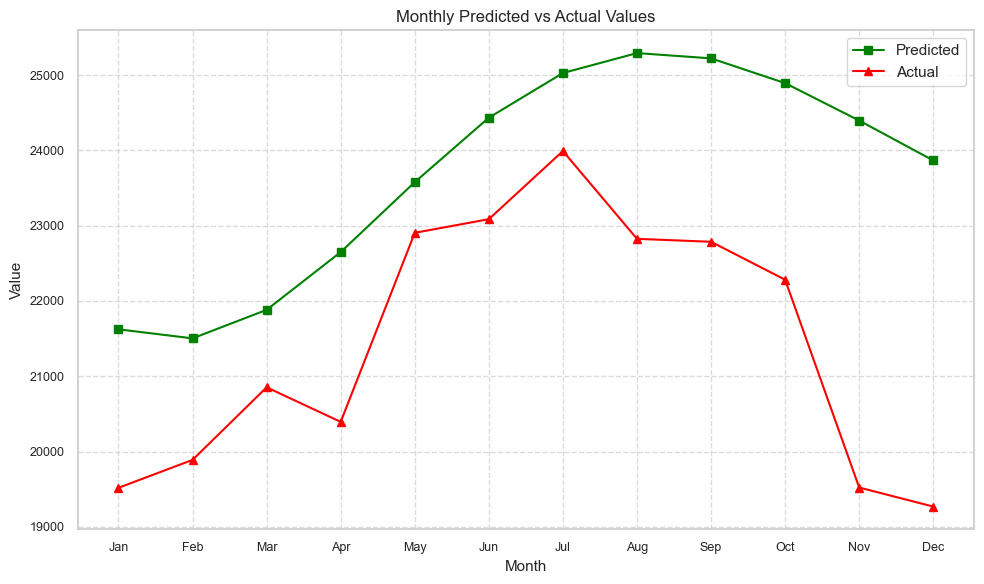

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming month_result is already calculated as shown in your code
# month_result = np.sum(rounded_result, axis=1)

# Create a list of month labels
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# Plot the month_result
plt.figure(figsize=(10, 6))
plt.plot(
    months,
    month_result[:, 0],
    marker="s",
    linestyle="-",
    color="green",
    label="Predicted",
)
plt.plot(
    months, month_result[:, 1], marker="^", linestyle="-", color="red", label="Actual"
)

# Add labels and title
plt.xlabel("Month")
plt.ylabel("Value")
plt.title("Monthly Predicted vs Actual Values")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
locations = data["District"].unique()
locations.sort()
n_location = len(locations)
time_points = sorted(data["time_key"].unique())
n_time = len(time_points)
location_map = {location: i for i, location in enumerate(locations)}
time_map = {time_point: i for i, time_point in enumerate(time_points)}

,Year,Month,sin_month,cos_month,time_key,District,crime_count,district_id,time_id
0,2020,1,0.0,1.000000,24241,1.0,1054.0,0,0
1,2020,1,0.0,1.000000,24241,2.0,795.0,1,0
2,2020,1,0.0,1.000000,24241,3.0,1028.0,2,0
3,2020,1,0.0,1.000000,24241,4.0,1074.0,3,0
4,2020,1,0.0,1.000000,24241,5.0,874.0,4,0
...,...,...,...,...,...,...,...,...,...
1315,2024,12,-0.5,0.866025,24300,19.0,1057.0,17,59
1316,2024,12,-0.5,0.866025,24300,20.0,383.0,18,59
1317,2024,12,-0.5,0.866025,24300,22.0,564.0,19,59
1318,2024,12,-0.5,0.866025,24300,24.0,598.0,20,59
